Inference investigation

In [1]:
cd ..

C:\Users\macle\Dropbox\mcode\SerpentAI


In [2]:
from plugins.SerpentMiniMetroGamePlugin.files.api.object_detector import ObjectDetector, draw_bounding_box, rgb2gray3d
import tensorflow as tf
import skimage.io
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from IPython.core.debugger import set_trace
from matplotlib import patches, patheffects
from itertools import islice

%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
%matplotlib inline

In [4]:
frozen_graph_path = "plugins/SerpentMiniMetroGamePlugin/files/ml_models/station_detector_m0_frozen_graph.pb"
labels_path = "plugins/SerpentMiniMetroGamePlugin/files/ml_models/station_detector_m0_label_map.json"

In [5]:
station_detector = ObjectDetector(frozen_graph_path, labels_path)

In [6]:
#test_image = skimage.io.imread("../../ml_train/station_detector/data/test/frame_1534972031.4780777.png")
test_image = skimage.io.imread("../../ml_train/station_detector/data/test/frame_1534972364.5022948.png")

#### Investigation

Loading single test image and getting input tensor

In [7]:
sess = tf.InteractiveSession(graph=station_detector.graph)

test_image = test_image[np.newaxis,...]
image_tensor = tf.get_default_graph().get_tensor_by_name("image_tensor:0")

In [10]:
from object_detection.anchor_generators.multiple_grid_anchor_generator import create_ssd_anchors
from object_detection.models.ssd_mobilenet_v1_feature_extractor_test import SsdMobilenetV1FeatureExtractorTest


def get_feature_map_shapes(image_height, image_width):
    """
    :param image_height: height in pixels
    :param image_width: width in pixels
    :returns: list of tuples containing feature map resolutions
    """
    
    feature_extractor = SsdMobilenetV1FeatureExtractorTest()._create_feature_extractor(
        depth_multiplier=1,
        pad_to_multiple=1,
    )
    
    image_batch_tensor = tf.zeros([1, image_height, image_width, 1])
    
    return [tuple(feature_map.get_shape().as_list()[1:3])
            for feature_map in feature_extractor.extract_features(image_batch_tensor)]

    

def get_feature_map_anchor_boxes(feature_map_shape_list, **anchor_kwargs):
    """
    :param feature_map_shape_list: list of tuples containing feature map resolutions
    :returns: dict with feature map shape tuple as key and list of [ymin, xmin, ymax, xmax] box co-ordinates
    """
    anchor_generator = create_ssd_anchors(**anchor_kwargs)

    anchor_box_lists = anchor_generator.generate(feature_map_shape_list)
    
    feature_map_boxes = {}

    with tf.Session() as sess:
        for shape, box_list in zip(feature_map_shape_list, anchor_box_lists):
            feature_map_boxes[shape] = sess.run(box_list.data['boxes'])
            
    return feature_map_boxes


def draw_boxes(boxes, figsize, nrows, ncols, grid=(0,0)):

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize) 

    for ax, box in zip(axes.flat, boxes):
        ymin, xmin, ymax, xmax = box
        ax.add_patch(patches.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, 
                                fill=False, edgecolor='red', lw=2))

        # add gridlines to represent feature map cells
        ax.set_xticks(np.linspace(0, 1, grid[0] + 1), minor=True)
        ax.set_yticks(np.linspace(0, 1, grid[1] + 1), minor=True)
        ax.grid(True, which='minor', axis='both')
              
    fig.tight_layout()
    
    return fig

In [9]:
feature_map_shape_list=get_feature_map_shapes(300, 300)

feature_map_shape_list

[(19, 19), (10, 10), (5, 5), (3, 3), (2, 2), (1, 1)]

In [58]:
boxes = get_feature_map_anchor_boxes(
    min_scale=0.2,
    max_scale=0.9,
    feature_map_shape_list=[(19,19)],
    aspect_ratios=(1.0, 0.3),
    reduce_boxes_in_lowest_layer=False,
    scales=[0.05],
    interpolated_scale_aspect_ratio=0
)

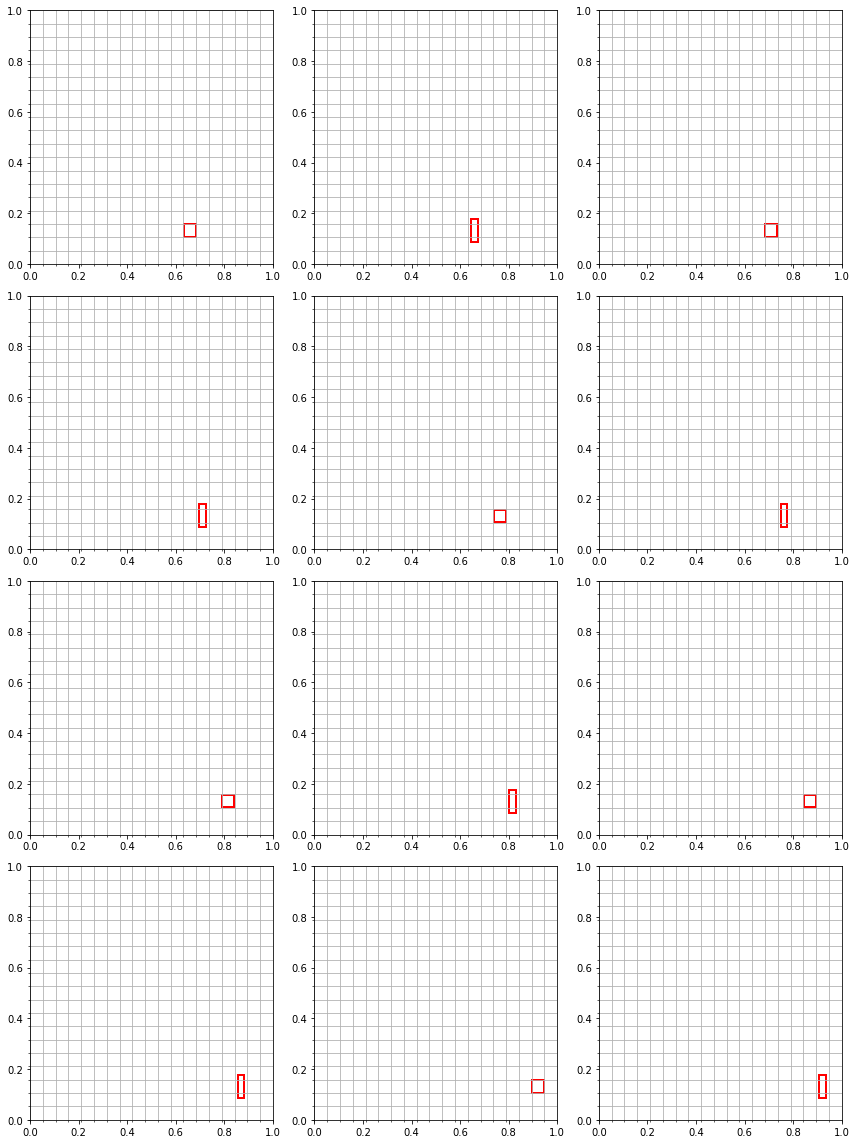

In [59]:
draw_boxes(boxes[(19,19)][100:112], figsize=(12,16), nrows=4, ncols=3, grid=(19,19))
plt.show()